# Import libraries, set config

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

import lightgbm as lgb

from eli5.sklearn import PermutationImportance
from shaphypetune import BoostBoruta

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GroupShuffleSplit, TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, mean_squared_error, precision_score

from colorama import Style, Fore
from time import sleep

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators


class CFG:
    load = False
    historical = False
    create_dataset = False
    cls_target_ratio_tp = 1.031
    cls_target_ratio_sl = 1.031
    ttype = 'both'
    patterns_to_filter = ['MACD', 'STOCH_RSI']
    select_features = False
    train_NN = False
    train_LGBM = True
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load MACD buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['MACD']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

# Load MACD sell data

In [3]:
ttype = 'sell'
pattern = ['MACD']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml')
  display(stat)

# Check if all dataframes has data for both timeframes 1h and 4h

In [4]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

AGIIUSDT 4h
SKLUSDT 4h
LAVEUSDT 1h
AMAUSDT 1h
CGROKUSDT 1h
KLAYUSDT 1h
MOBILEUSDT 1h
GNOUSDT 1h
DODOUSDT 4h
MLUSDT 1h
ZKPEPEUSDT 1h
BTGUSDT 4h
MDTUSDT 1h
AGDUSDT 1h
NADAUSDT 1h
UBXUSDT 1h
MBDUSDT 4h
KUJIUSDT 1h
KOINUSDT 1h
HNKUSDT 1h
MMVGUSDT 1h
OPNUSDT 1h
BIFIUSDT 4h
ETEUSDT 1h
ALPHAUSDT 1h
SUPERPEPEUSDT 1h


# Prepare data

In [5]:
# Get configs
configs = ConfigFactory.factory(environ).configs

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add RSI
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
     # add MACD
    macd = indicators.MACD(ttype, configs)
    # df = macd.get_indicator(df, '', '', 0)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    # df = trend.get_indicator(df, '', '', 0)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 
                        'macd_dir', 'macdsignal', 'macdsignal_dir']
    # merge higher timeframe indicators with working timeframe
    df = pd.merge(df, df_higher[higher_features], how='left', on='time')
    df.ffill(inplace=True)
    df = df.dropna()
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + step, step):
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, :].reset_index(drop=True)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0
                
                # set sl flag if price goes through stop-loss threshold before it goes through take-profit threshold
                if (row['ttype'].values[0] == 'buy' and target_sell_sl == 1) or (row['ttype'].values[0] == 'sell' and target_buy_sl == 1):
                    break
                
                if (row['ttype'].values[0] == 'buy' and target_buy_tp == 1) or (row['ttype'].values[0] == 'sell' and target_sell_tp == 1):
                    row['target'] = 1
                    break
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    return train_df

if CFG.create_dataset:
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # display(df.head())
    # display(df.shape)


# Check pattern / target distribution

In [6]:
# ticker num for buy/sell: 409/425
if CFG.create_dataset:
    display(train_buy['ttype'].value_counts()) # 7906
    display(train_sell['ttype'].value_counts()) # 15480
    display(train_buy[['target', 'pattern']].value_counts()) # 5044 / 2862
    display(train_sell[['target', 'pattern']].value_counts()) # 8514 / 6966

# Check target corectness

In [7]:
# i = 557

# x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
# y = x.iloc[i]
# low_price, high_price = y['close'] / CFG.cls_target_ratio_tp, y['close'] * CFG.cls_target_ratio_tp,
# print(y['ticker'], y['time'], y['ttype'], y['target'])

# tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}-SWAP_4h.pkl')

# tmp_df_1h['low_price'] = low_price
# tmp_df_1h['high_price'] = high_price
# idx = tmp_df_1h[tmp_df_1h['time'] == y['time']].index[0]

# tmp_df_1h = tmp_df_1h.iloc[idx:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

# if y['ttype'] == 'buy':
#     tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
# else:
#     tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']

# tmp_df_1h

# Compare indicator values for bot and optimizer

In [8]:
# ttype = 'buy'
# timeframe = '4h'
# ticker = 'RONUSDT'
# configs = ConfigFactory.factory(environ).configs

# # x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_{timeframe}_{ttype}_12_28_0.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # x = x.loc[~x['linear_reg'].isna()].reset_index(drop=True)
# y = y[['time', 'open', 'high', 'low', 'close', 'volume']][-600:].reset_index(drop=True)
# # for c in ['open', 'high', 'low', 'close', 'volume']:
# #     if y.shape[0] >= 50:
# #         if c == 'volume':
# #             y.iloc[-1, y.columns.get_loc(c)] = 0
# #         else:
# #             y.iloc[-1, y.columns.get_loc(c)] = y.iloc[-2, y.columns.get_loc('close')]
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)
# # add MACD
# macd = indicators.MACD(ttype, configs)
# y = macd.get_indicator(y, '', '', 0)

# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# # x = x[cols]
# # display(x.tail(20))

# y = y[cols]
# y.tail(20)[:-1]

# Check buy trades correctness

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Check sell trades correctness

In [10]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Concat buy and sell datasets

,time,open,high,low,close,volume,rsi,stoch_slowk,stoch_slowd,stoch_slowk_dir,stoch_slowd_dir,stoch_diff,atr,close_smooth,linear_reg,linear_reg_angle,macd,macdhist,macd_dir,macdsignal,macdsignal_dir,open_prev_4,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_slowk_dir_prev_4,stoch_slowd_dir_prev_4,stoch_diff_prev_4,atr_prev_4,close_smooth_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macd_dir_prev_4,macdsignal_prev_4,macdsignal_dir_prev_4,ticker,pattern,open_prev_8,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_slowk_dir_prev_8,stoch_slowd_dir_prev_8,stoch_diff_prev_8,atr_prev_8,close_smooth_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macd_dir_prev_8,macdsignal_prev_8,macdsignal_dir_prev_8,open_prev_12,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_slowk_dir_prev_12,stoch_slowd_dir_prev_12,stoch_diff_prev_12,atr_prev_12,close_smooth_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macd_dir_prev_12,macdsignal_prev_12,macdsignal_dir_prev_12,open_prev_16,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_slowk_dir_prev_16,stoch_slowd_dir_prev_16,stoch_diff_prev_16,atr_prev_16,close_smooth_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macd_dir_prev_16,macdsignal_prev_16,macdsignal_dir_prev_16,open_prev_20,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_slowk_dir_prev_20,stoch_slowd_dir_prev_20,stoch_diff_prev_20,atr_prev_20,close_smooth_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macd_dir_prev_20,macdsignal_prev_20,macdsignal_dir_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_slowk_dir_prev_24,stoch_slowd_dir_prev_24,stoch_diff_prev_24,atr_prev_24,close_smooth_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macd_dir_prev_24,macdsignal_prev_24,macdsignal_dir_prev_24,open_prev_28,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_slowk_dir_prev_28,stoch_slowd_dir_prev_28,stoch_diff_prev_28,atr_prev_28,close_smooth_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macd_dir_prev_28,macdsignal_prev_28,macdsignal_dir_prev_28,open_prev_32,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_slowk_dir_prev_32,stoch_slowd_dir_prev_32,stoch_diff_prev_32,atr_prev_32,close_smooth_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macd_dir_prev_32,macdsignal_prev_32,macdsignal_dir_prev_32,open_prev_36,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_slowk_dir_prev_36,stoch_slowd_dir_prev_36,stoch_diff_prev_36,atr_prev_36,close_smooth_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macd_dir_prev_36,macdsignal_prev_36,macdsignal_dir_prev_36,open_prev_40,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_slowk_dir_prev_40,stoch_slowd_dir_prev_40,stoch_diff_prev_40,atr_prev_40,close_smooth_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macd_dir_prev_40,macdsignal_prev_40,macdsignal_dir_prev_40,open_prev_44,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_slowk_dir_prev_44,stoch_slowd_dir_prev_44,stoch_diff_prev_44,atr_prev_44,close_smooth_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macd_dir_prev_

<AxesSubplot:>

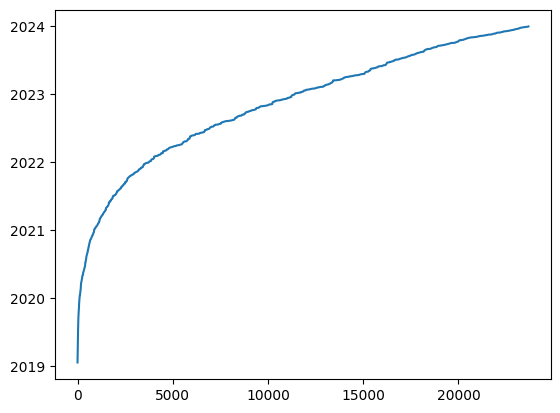

In [11]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')


df = df[df['pattern'].isin(CFG.patterns_to_filter)]

display(df)

df = df.sort_values('time')
# do not consider the last signals - they may contain erroneus signals
df = df[df['time'] < df['time'].max()].reset_index(drop=True)
train_df = df

df['time'].plot()


# Check the last signals

In [12]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x[['time', 'ticker', 'ttype']].tail(30)

,time,ticker,ttype
24778,2023-12-29 23:00:00,DREPUSDT,sell
24779,2023-12-29 23:00:00,PENDLEUSDT,sell
24780,2023-12-29 23:00:00,WNXMUSDT,sell
24781,2023-12-29 23:00:00,LTCUSDT,sell
24782,2023-12-29 23:00:00,STETHUSDT,sell
24783,2023-12-29 23:00:00,ALGOUSDT,sell
24784,2023-12-29 23:00:00,FILUSDT,sell
24785,2023-12-29 23:00:00,XNOUSDT,sell
24786,2023-12-29 23:00:00,SPACEUSDT,sell
24787,2023-12-29 23:00:00,METHUSDT,sell


# Select features with BORUTA feature importance

In [13]:
import pandas as pd
import lightgbm as lgb
from shaphypetune import BoostBoruta

if CFG.select_features:

  df.to_csv('df.csv', index=False)
  df_boruta = pd.read_csv('df.csv')
  os.remove('df.csv')
  
  params = {
            'n_estimators': 1000,
            'learning_rate': 0.02,
          #   'early_stopping_round': 100,
            'max_depth': 10,
            'subsample' : 0.7,
            'colsample_bytree': 0.85,
            'num_leaves': 24,
            'verbosity': -1,
            'importance_type': 'gain',
            'max_bin': 255,
            'reg_alpha': 1e-6,
            'reg_lambda': 1e-8
          }

  boruta_df_ = pd.DataFrame()
  features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]

  X, y, time = df_boruta[features], df_boruta['target'], df_boruta['time']

  tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
  eval_metric = 'logloss'

  # Stratify based on Class and Alpha (3 types of conditions)
  for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

      print(f'Fold: {fold}')
      # Split the dataset according to the fold indexes.
      X_train = X.iloc[train_idx]
      X_val = X.iloc[val_idx]
      y_train = y.iloc[train_idx]
      y_val = y.iloc[val_idx]

      clf = lgb.LGBMClassifier(**params)
      model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False)
      model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
              eval_metric='logloss', 
              callbacks=[lgb.log_evaluation(100)])

      boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
      if boruta_df_.shape[0] == 0:
          boruta_df_ = boruta_importance_df.copy()
      else:
          boruta_df_ += boruta_importance_df

  boruta_df_ = boruta_df_.sort_values('importance')
  boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

  del df_boruta

# Select features with permutation importance and GBM feature importance

In [14]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


params = {
          'n_estimators': 1000,
          'learning_rate': 0.02,
        #   'early_stopping_round': 100,
          'max_depth': 9,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-8
        }

task_type = 'cls'

if task_type == 'cls':
    params['boosting_type'] = 'dart'
    params['objective'] = 'binary'
else:
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'

if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(df, permut=True)

# Combine importances and save them

In [15]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance_{CFG.ttype}.csv')
else:
    fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')

# Train_test split based on ticker groups

In [16]:
idxs = list()

def model_train(df, train_df, features, task_type, how, n_folds, low_bound, high_bound, train_test): 
    X, time = train_df[features], train_df['time']
    # X = pd.concat([X, pd.get_dummies(train_df[['ttype']], drop_first=True)], axis=1)
    y = train_df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(train_df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(train_df) * 2) // (n_folds * 3))

        print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            val_idx = time[time > max_time].index.tolist()
            
            idxs.append((fit_idx, val_idx))
            
            if fold == 0:
                first_val_idx = val_idx[0]
            
            print(f'Fold #{fold + 1}')
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            display(y_val.value_counts())
            display(train_df.loc[val_idx[0], 'time'])
            display(train_df.loc[val_idx[-1], 'time'])
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                        eval_metric='logloss')#, callbacks = [lgb.log_evaluation(100)])

            val_preds = model.predict_proba(X_val)
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:,1], low_bound, high_bound)
            print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                  f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n')
            oof[val_idx, 0] = val_preds[:,1]

        return oof, model, first_val_idx
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        model = lgb.LGBMClassifier(**params)
        model.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        return np.zeros([df.shape[0], 1]), model, None

def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    fi = fi['Feature'].head(feature_num)
    feature_dict = defaultdict(list)
    features = list()

    # exclude some features by their numbers
    feature_idx = [i for i in range(feature_num) if i not in features_to_exclude]
    fi = (np.array(fi)[feature_idx])
    
    for f in fi:
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf[oof < low_bound] = 0
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]

    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

train_test = 'full' # fold, test, full, inference
feature_num = 163

low_bound, high_bound = 0.32, 0.68
params = {
    'boosting_type': 'dart',
    'n_estimators': 1500,
    'learning_rate': 0.02,
    # 'early_stopping_round': 50,
    'max_depth': 10,
    'colsample_bytree': 0.85,
    'subsample': 0.85,
    'subsample_freq': 1,
    'num_leaves': 23,
    'verbosity': -1,
    'max_bin': 255,
    'reg_alpha': 1e-6,
    'reg_lambda': 1e-7,
    'objective': 'binary',
    # 'is_unbalance': True,
    # 'class_weight': 'balanced',
    'metric': 'average_precision'
    }

if CFG.train_LGBM:
    # for j in tqdm(range(1, 162)):
    #     print(j)
    features_to_exclude = []
    fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')
    features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
    
    if train_test != 'inference':
        oof, model, first_val_idx = model_train(df, train_df, features, task_type=task_type, how='lgbm', n_folds=5, low_bound=low_bound, high_bound=high_bound, train_test=train_test)
    if train_test == 'fold':
        # fold
        y = train_df['target'][first_val_idx:]
        oof = oof[first_val_idx:]
        oof_val_score = log_loss(y, oof)
        oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
        print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
              f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}')
        # feature_exclude_dict[j] = (oof_val_score, oof_conf_prec_score, oof_conf_obj_pct)
    elif train_test == 'full':
        joblib.dump(model, f'lgbm.pkl')
        # save feature dictionary for further inference
        with open(f'features.json', 'w') as f:
            json.dump(feature_dict, f)
    

Train on full data
[100]	training's binary_logloss: 0.649646	training's average_precision: 0.773331
[200]	training's binary_logloss: 0.636836	training's average_precision: 0.790212
[300]	training's binary_logloss: 0.623231	training's average_precision: 0.807365
[400]	training's binary_logloss: 0.611019	training's average_precision: 0.821601
[500]	training's binary_logloss: 0.59885	training's average_precision: 0.837319
[600]	training's binary_logloss: 0.594284	training's average_precision: 0.847511
[700]	training's binary_logloss: 0.584824	training's average_precision: 0.856815
[800]	training's binary_logloss: 0.578786	training's average_precision: 0.865772
[900]	training's binary_logloss: 0.570435	training's average_precision: 0.876449
[1000]	training's binary_logloss: 0.563991	training's average_precision: 0.884482
[1100]	training's binary_logloss: 0.557201	training's average_precision: 0.893383
[1200]	training's binary_logloss: 0.552911	training's average_precision: 0.898588
[1300]	

In [17]:
# Training with 163 features
# Fold #1
# 1    8724
# 0    6584
# Name: target, dtype: int64Timestamp('2022-08-13 23:00:00')Timestamp('2023-12-27 15:00:00')
# Logloss: 0.6537728969368747, Confident objects precision: 0.7358018513885414
# Number of confident objects 3997, % of confident objects: 0.2611053044159916

# Fold #2
# 1    6954
# 0    5337
# Name: target, dtype: int64Timestamp('2022-12-15 07:00:00')Timestamp('2023-12-27 15:00:00')
# Logloss: 0.6467260503589031, Confident objects precision: 0.7615062761506276
# Number of confident objects 2868, % of confident objects: 0.23334146936783012

# Fold #3
# 1    5198
# 0    3932
# Name: target, dtype: int64Timestamp('2023-04-07 07:00:00')Timestamp('2023-12-27 15:00:00')
# Logloss: 0.6462801439038055, Confident objects precision: 0.7637872132747682
# Number of confident objects 2049, % of confident objects: 0.2244249726177437

# Fold #4
# 1    3513
# 0    2601
# Name: target, dtype: int64Timestamp('2023-07-24 03:00:00')Timestamp('2023-12-27 15:00:00')
# Logloss: 0.6446183096074545, Confident objects precision: 0.7877049180327869
# Number of confident objects 1220, % of confident objects: 0.1995420346745175

# Fold #5
# 1    1731
# 0    1230
# Name: target, dtype: int64Timestamp('2023-10-30 07:00:00')Timestamp('2023-12-27 15:00:00')
# Logloss: 0.6276787349015992, Confident objects precision: 0.821256038647343
# Number of confident objects 621, % of confident objects: 0.20972644376899696

# Total fold Logloss: 0.6440395952515509, Total confident objects precision: 0.7760072158749248
# Number of confident objects: 3326, Total % of confident objects: 0.2172720146328717

# Display PR curve

In [18]:
from sklearn.metrics import PrecisionRecallDisplay

if train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.72

# Find the best threshold

In [19]:
from icecream import ic

if train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    for hb in np.arange(0.5, 0.85, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y, oof, 1-hb, hb)
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        ic(bound, prec_score, obj_num, obj_pct)

    line1 = plt.plot(np.arange(0.5, 0.85, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.5, 0.85, 0.01), obj_pct_list, label='object pct')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

In [20]:
# vol 1e6
# ic| bound: 0.5, prec_score: 0.62551, obj_num: 10481, obj_pct: 0.8
# ic| bound: 0.51, prec_score: 0.63125, obj_num: 10164, obj_pct: 0.78
# ic| bound: 0.52, prec_score: 0.63461, obj_num: 9899, obj_pct: 0.76
# ic| bound: 0.53, prec_score: 0.63983, obj_num: 9576, obj_pct: 0.73
# ic| bound: 0.54, prec_score: 0.6449, obj_num: 9234, obj_pct: 0.71
# ic| bound: 0.55, prec_score: 0.64998, obj_num: 8848, obj_pct: 0.68
# ic| bound: 0.56, prec_score: 0.65674, obj_num: 8463, obj_pct: 0.65
# ic| bound: 0.57, prec_score: 0.66484, obj_num: 8041, obj_pct: 0.62
# ic| bound: 0.58, prec_score: 0.67203, obj_num: 7577, obj_pct: 0.58
# ic| bound: 0.59, prec_score: 0.67843, obj_num: 7168, obj_pct: 0.55
# ic| bound: 0.6, prec_score: 0.68426, obj_num: 6800, obj_pct: 0.52
# ic| bound: 0.61, prec_score: 0.69121, obj_num: 6396, obj_pct: 0.49
# ic| bound: 0.62, prec_score: 0.70216, obj_num: 5926, obj_pct: 0.45
# ic| bound: 0.63, prec_score: 0.70704, obj_num: 5482, obj_pct: 0.42
# ic| bound: 0.64, prec_score: 0.71542, obj_num: 5053, obj_pct: 0.39
# ic| bound: 0.65, prec_score: 0.72519, obj_num: 4636, obj_pct: 0.35
# ic| bound: 0.66, prec_score: 0.73463, obj_num: 4213, obj_pct: 0.32
# ic| bound: 0.67, prec_score: 0.74347, obj_num: 3828, obj_pct: 0.29
# ic| bound: 0.68, prec_score: 0.75194, obj_num: 3471, obj_pct: 0.27
# ic| bound: 0.69, prec_score: 0.76187, obj_num: 3074, obj_pct: 0.24
# ic| bound: 0.7, prec_score: 0.77096, obj_num: 2720, obj_pct: 0.21
# ic| bound: 0.71, prec_score: 0.78214, obj_num: 2396, obj_pct: 0.18
# ic| bound: 0.72, prec_score: 0.79732, obj_num: 2092, obj_pct: 0.16
# ic| bound: 0.73, prec_score: 0.80855, obj_num: 1802, obj_pct: 0.14
# ic| bound: 0.74, prec_score: 0.82368, obj_num: 1520, obj_pct: 0.12
# ic| bound: 0.75, prec_score: 0.83815, obj_num: 1279, obj_pct: 0.1
# ic| bound: 0.76, prec_score: 0.8422, obj_num: 1071, obj_pct: 0.08
# ic| bound: 0.77, prec_score: 0.85244, obj_num: 881, obj_pct: 0.07
# ic| bound: 0.78, prec_score: 0.86192, obj_num: 717, obj_pct: 0.05
# ic| bound: 0.79, prec_score: 0.87895, obj_num: 570, obj_pct: 0.04
# ic| bound: 0.8, prec_score: 0.88532, obj_num: 436, obj_pct: 0.03
# ic| bound: 0.81, prec_score: 0.89275, obj_num: 345, obj_pct: 0.03
# ic| bound: 0.82, prec_score: 0.89961, obj_num: 259, obj_pct: 0.02
# ic| bound: 0.83, prec_score: 0.91919, obj_num: 198, obj_pct: 0.02
# ic| bound: 0.84, prec_score: 0.92949, obj_num: 156, obj_pct: 0.01